# Bike Sharing Assignment
## Import all required libraries

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Data Loading

In [78]:
file_path = "day.csv"
df = pd.read_csv(file_path)

### Understanding the data

In [79]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [80]:
df.shape

(730, 16)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [82]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [83]:
# Check for null values
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

### Observations:
* Total rows and cols = 730 and 16
* No null values
* **instant** is unique ID column

## Data preperation and EDA
### Data Cleaning and Transformation
* Drop columns **instant**, **casual**, **registered**:
    * **instant** is a unique ID 
    * **casual** and **registered** column values can be determined only after a customer uses the bike, 
        so these columns might not be there in the input file later
* Values for **season** are 1, 2, 3, 4 which does not look understandable,
    so lets encode them to proper season as per data dictionary
* Values for **weathersit** are 1, 2, 3 which does not look understandable,
    so lets encode them to proper weather as per data dictionary

In [84]:
# df["day"] = pd.DatetimeIndex(df["dteday"]).day
df = df.drop(["instant", "casual", "registered", "dteday"], axis=1)

In [85]:
print(df["season"].unique())
print(df["weathersit"].unique())

[1 2 3 4]
[2 1 3]


In [86]:
new_value_dict = {"season" : {1:"spring", 2:"summer", 3:"fall", 4:"winter"}, 
                  "weathersit" : {1: "Clear", 2: "Mist", 3: "Light Snow/Rain", 4: "Heavy Snow/Rain"}, 
                  "weekday" : {0: "Sunday", 1:"Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 5:"Friday", 
                               6:"Saturday"},
                  "mnth" : {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"June", 7:"July", 8:"Aug", 
                            9:"Sept", 10:"Oct", 11:"Nov", 12:"Dec"}}

for col in new_value_dict.keys():
    df[col] = df[col].apply(lambda x : new_value_dict[col][x])

In [87]:
df.head()        

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [88]:
# Some column values looks like numerical variables but they are categorical, 
# So lets convert them to "category" type. This will be helpful in correlation metrix
cols= ["yr", "holiday", "weekday", "workingday"]
for col in cols:
    df[col] = df[col].astype('category')

### Visualize Data

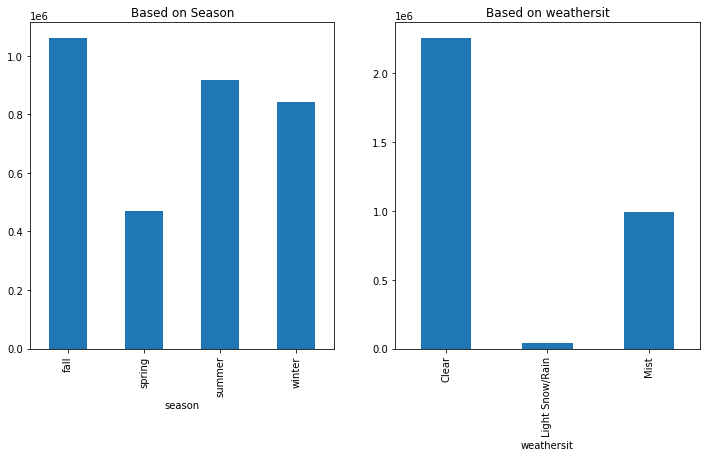

In [89]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1, title="Based on Season")
ax2 = fig.add_subplot(1, 2, 2, title="Based on weathersit")
df.groupby(['season'])['cnt'].sum().plot.bar(ax=ax1)
df.groupby(['weathersit'])['cnt'].sum().plot.bar(ax=ax2)
plt.show()

### Observation: 
    1. When there was fall, more customers used shared bike
    2. Most people used shared bike when the weather was clear
    3. There is no demand for bike when it is raining/snowing heavily

In [90]:
len(df[df["weathersit"] == "Heavy Snow/Rain"])
# This clearly proves 3rd point

0

<AxesSubplot:xlabel='weekday', ylabel='cnt'>

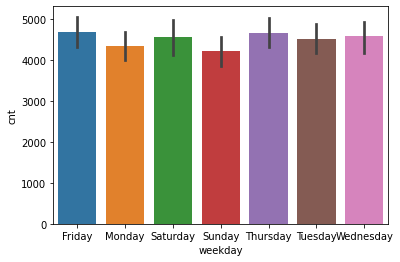

In [91]:
sns.barplot(data=df, x="weekday", y="cnt")

### Observation: 
    1. There is no significant difference in the usage of shared bike during weekdays

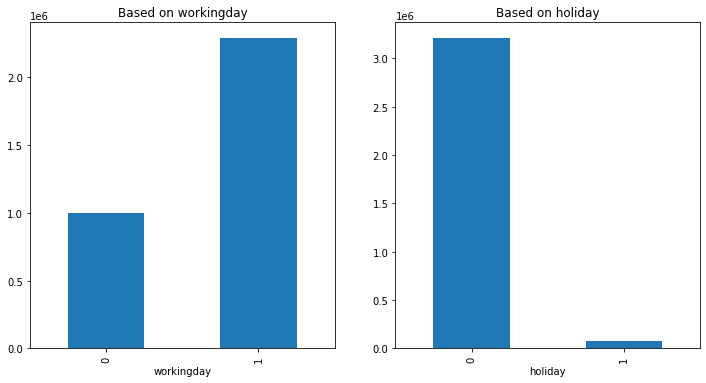

In [92]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1, title="Based on workingday")
ax2 = fig.add_subplot(1, 2, 2, title="Based on holiday")
df.groupby(['workingday'])['cnt'].sum().plot.bar(ax=ax1)
df.groupby(['holiday'])['cnt'].sum().plot.bar(ax=ax2)
plt.show()

### Observation: 
    1. Demand for shared bikes is more during working day and less during holidays

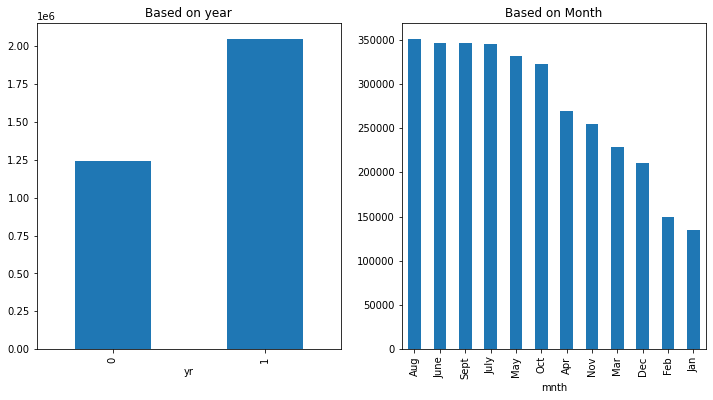

In [93]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Based on year")
ax2 = fig.add_subplot(1, 2, 2, title="Based on Month")

df.groupby(['yr'])['cnt'].sum().plot.bar(ax=ax1)
df.groupby(['mnth']).sum().sort_values('cnt', ascending=False)['cnt'].plot.bar(ax=ax2)
plt.show()

### Observation: 
    1. Demand is increased in 2019 as compared to 2018, which indicates that it might again increase in 2020
    2. Most people ave used shared bike in the month of June, July, August and September

### Correlation

<AxesSubplot:>

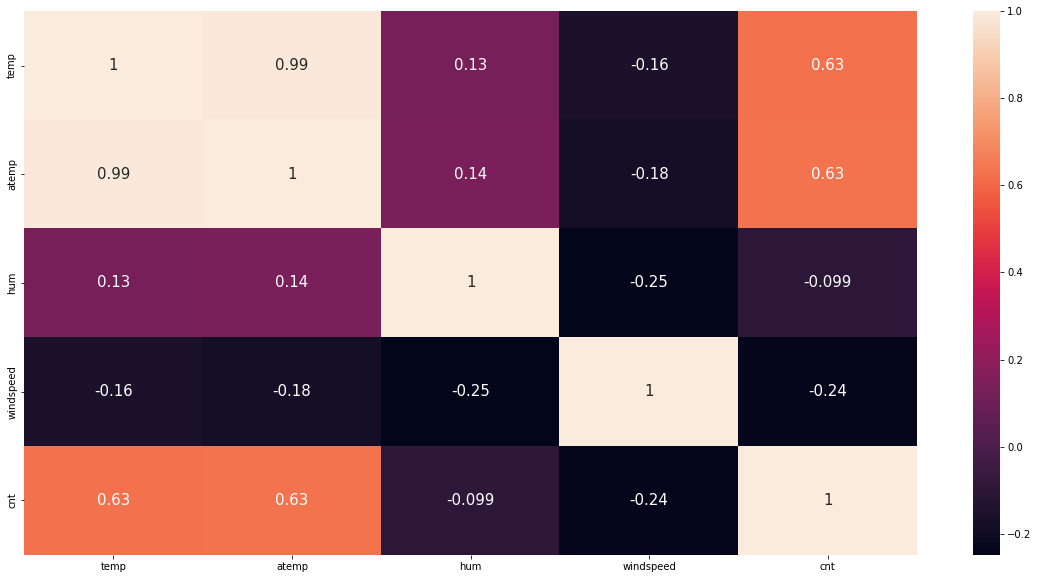

In [94]:
plt.subplots(figsize=(20,10))
corr= df.corr()
sns.heatmap(corr, annot=True, annot_kws={'size':15} )

In [95]:
def one_hot_encoding(df, col):
    df = pd.concat([df, pd.get_dummies(df[col], drop_first=True)], axis=1)
    df = df.drop([col], axis=1)
    return df

In [96]:
col_list = ['season', 'weathersit', 'weekday', 'mnth']
for col in col_list:
    df = one_hot_encoding(df, col)

In [97]:
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,July,June,Mar,May,Nov,Oct,Sept
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,1,0,0,0,0,0,0,0


## Input Data splitting

In [98]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3, random_state=100)

In [99]:
print(df_train.shape)
print(df_test.shape)

(511, 30)
(219, 30)


### Rescaling
#### Min-Max scaling

In [100]:
# scale only numerical variable
scaler = MinMaxScaler()
# Create a lit of numeric variable
numeric_var = ["temp", "atemp", "hum", "windspeed", "cnt"]

In [101]:
df_train[numeric_var] = scaler.fit_transform(df_train[numeric_var])
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,July,June,Mar,May,Nov,Oct,Sept
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,...,0,0,0,0,0,0,0,0,1,0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,...,1,0,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,0,0,0,0,0,0,0


In [102]:
df_train.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'spring', 'summer', 'winter', 'Light Snow/Rain', 'Mist',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'Aug', 'Dec', 'Feb', 'Jan', 'July', 'June', 'Mar', 'May', 'Nov', 'Oct',
       'Sept'],
      dtype='object')

In [103]:
df_train[numeric_var].describe()

,temp,atemp,hum,windspeed,cnt
count,511.000000,511.000000,511.000000,511.000000,511.000000
mean,0.537386,0.513133,0.650333,0.320844,0.514186
std,0.225640,0.212202,0.145741,0.169639,0.224737
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.341151,0.332910,0.538858,0.199179,0.356765
50%,0.542077,0.529300,0.653499,0.298098,0.519673
75%,0.735215,0.688457,0.754401,0.414438,0.688737
max,1.000000,1.000000,1.000000,1.000000,1.000000


### Training the model

<AxesSubplot:>

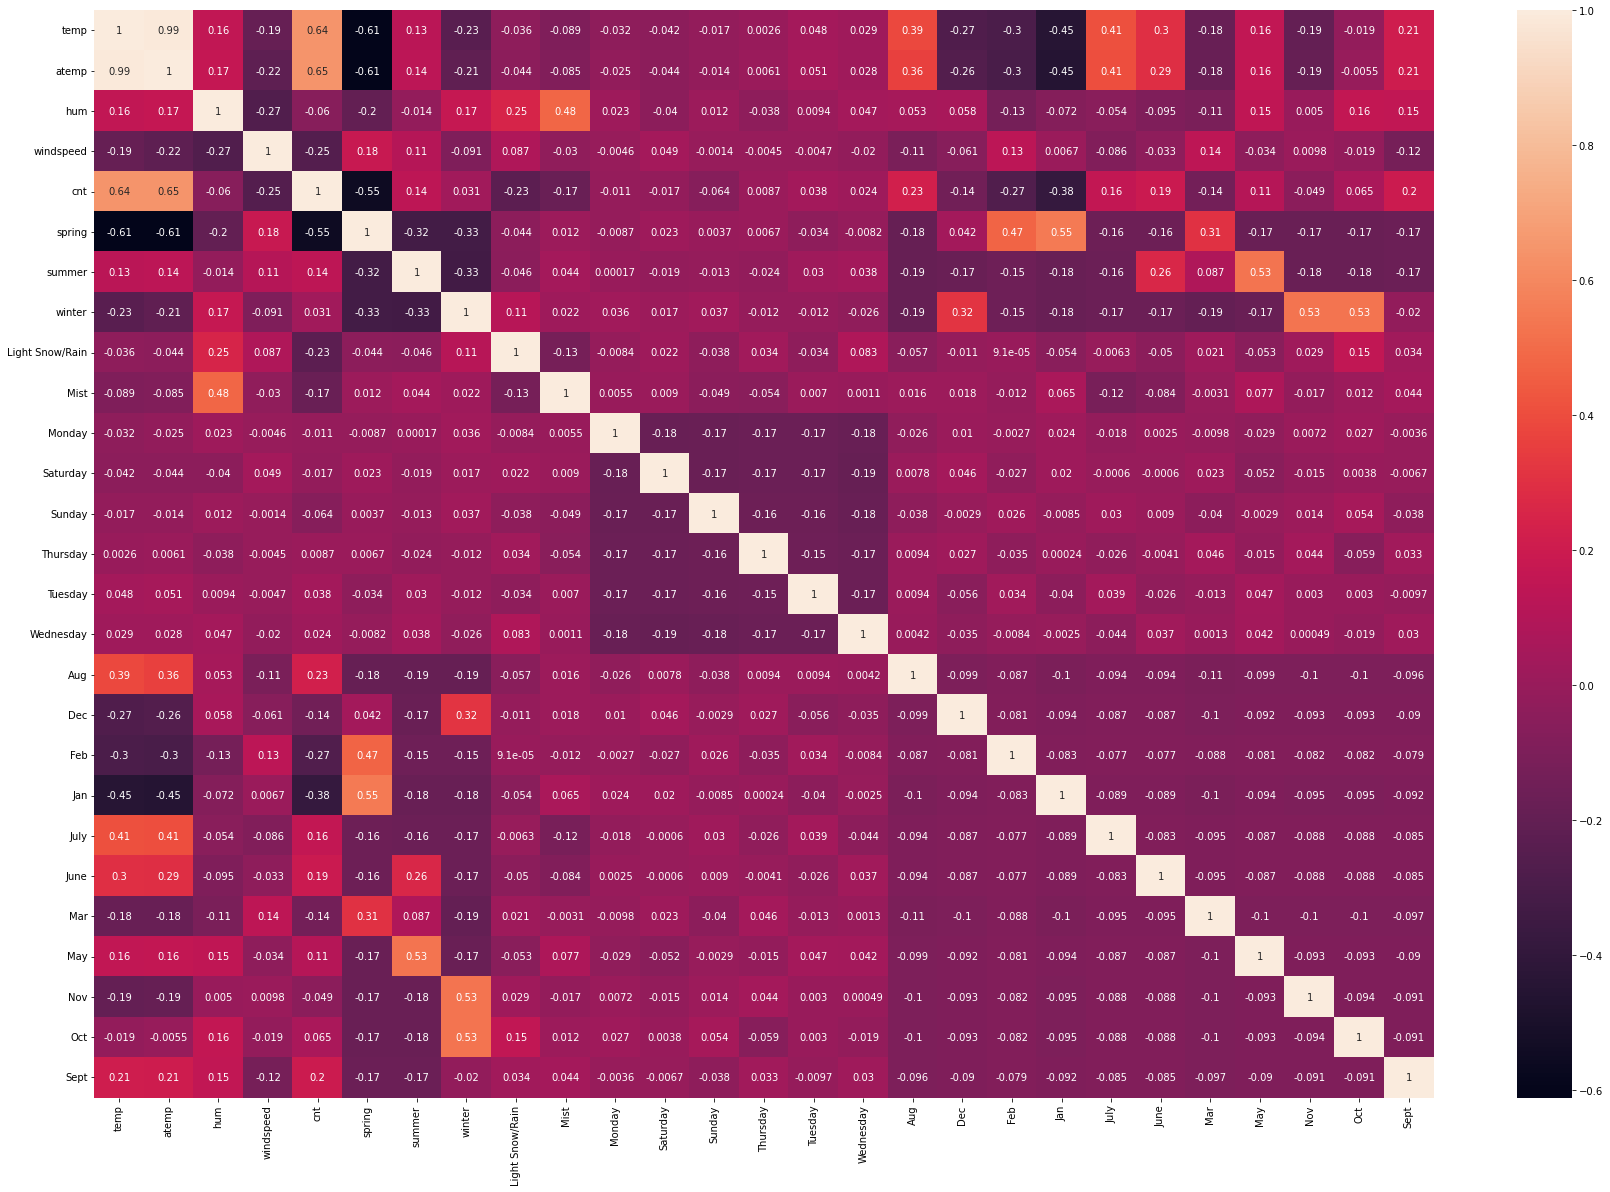

In [104]:
plt.subplots(figsize=(30,20))

corr = df_train.corr()
sns.heatmap(corr, annot=True, annot_kws={'size':10} )

In [105]:
y_train = df_train.pop('cnt')
X_train = df_train

In [106]:
print(y_train.head())
print(X_train.head())

653    0.864243
576    0.827658
426    0.465255
728    0.204096
482    0.482973
Name: cnt, dtype: float64
    yr holiday workingday      temp     atemp       hum  windspeed  spring  \
653  1       0          1  0.509887  0.501133  0.575354   0.300794       0   
576  1       0          1  0.815169  0.766351  0.725633   0.264686       0   
426  1       0          0  0.442393  0.438975  0.640189   0.255342       1   
728  1       0          0  0.245101  0.200348  0.498067   0.663106       1   
482  1       0          0  0.395666  0.391735  0.504508   0.188475       0   

     summer  winter  ...  Dec  Feb  Jan  July  June  Mar  May  Nov  Oct  Sept  
653       0       1  ...    0    0    0     0     0    0    0    0    1     0  
576       0       0  ...    0    0    0     1     0    0    0    0    0     0  
426       0       0  ...    0    0    0     0     0    1    0    0    0     0  
728       0       0  ...    1    0    0     0     0    0    0    0    0     0  
482       1       0  ... 

### Model Building

In [107]:
# Build model for all features
# add a constant
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     99.76
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          7.47e-181
Time:                        16:27:51   Log-Likelihood:                 527.86
No. Observations:                 511   AIC:                            -997.7
Df Residuals:                     482   BIC:                            -874.9
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2438      0.035      6.899      0.000       0.174       0.313
yr                  0.2330      0.008     28.864      0.000       0.217       0.249
holiday             0.0111      0.024      0.459      0.647      -0.036       0.059
workingday          0.0964      0.012      7.846      0.000       0.072       0.121
temp                0.3862      0.142      2.713      0.007       0.106       0.666
atemp               0.0601      0.139      0.434      0.664      -0.212       0.332
hum                -0.1531      0.039     -3.963      0.000      -0.229      -0.077
windspeed          -0.1838      0.026     -6.965      0.000      -0.236      -0.132
spring             -0.0455      0.030     -1.513      0.131      -0.104       0.014
summer              0.0424      0.026      1.617      0.107      -0.009       0.094
winter              0.1069      0.028      3.818      0.000       0.052       0.162
Light Snow/Rain    -0.2556      0.026     -9.650      0.000      -0.308      -0.204
Mist               -0.0598      0.010     -5.725      0.000      -0.080      -0.039
Monday             -0.0217      0.015     -1.408      0.160      -0.052       0.009
Saturday            0.0953      0.014      6.916      0.000       0.068       0.122
Sunday              0.0410      0.014      2.928      0.004       0.013       0.068
Thursday           -0.0097      0.016     -0.620      0.535      -0.040       0.021
Tuesday            -0.0168      0.016     -1.085      0.278      -0.047       0.014
Wednesday          -0.0059      0.015     -0.392      0.695      -0.035       0.024
Aug                 0.0226      0.034      0.668      0.505      -0.044       0.089
Dec                -0.0440      0.034     -1.306      0.192      -0.110       0.022
Feb                -0.0324      0.033     -0.981      0.327      -0.097       0.032
Jan                -0.0630      0.034     -1.873      0.062      -0.129       0.003
July               -0.0324      0.035     -0.923      0.356      -0.101       0.037
June                0.0063      0.025      0.252      0.801      -0.043       0.055
Mar                 0.0017      0.025      0.068      0.946      -0.047       0.050
May                 0.0258      0.021      1.219      0.223      -0.016       0.067
Nov                -0.0396      0.036     -1.086      0.278      -0.111       0.032
Oct                 0.0107      0.036      0.299      0.765      -0.060       0.081
Sept                0.0872      0.032      2.723      0.007       0.024       0.150
==============================================================================
Omnibus:                       85.644   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              240.466
Skew:                          -0.811   Prob(JB):                     6.07

### Calculate VIF

In [108]:
def calculate_VIF(X_train):
    vif = pd.DataFrame()
    vif["Feature"] = X_train.columns
    vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif["VIF"] = round(vif["VIF"], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    print(vif)

In [109]:
calculate_VIF(X_train)

            Feature    VIF
2        workingday  85.79
3              temp  66.89
4             atemp  56.03
13         Saturday  19.71
14           Sunday  18.34
7            spring  10.77
9            winter   9.52
8            summer   8.30
26              Nov   6.79
27              Oct   6.57
18              Aug   6.47
21              Jan   5.90
19              Dec   5.68
22             July   5.64
28             Sept   4.92
1           holiday   4.51
20              Feb   4.39
24              Mar   3.47
23             June   2.86
25              May   2.24
5               hum   2.05
12           Monday   1.98
17        Wednesday   1.94
15         Thursday   1.83
16          Tuesday   1.81
11             Mist   1.60
10  Light Snow/Rain   1.30
6         windspeed   1.30
0                yr   1.06


# RFE

In [110]:
def rfe_top_features(n):
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    rfe = RFE(lm, n)
    rfe = rfe.fit(X_train, y_train)
    return X_train.columns[rfe.support_]

def regression_model(X_train, y_train, col_list):
    # add a constant
    X = X_train[col_list]
    X_train_sm = sm.add_constant(X)
    lr = sm.OLS(y_train, X_train_sm)
    lr_model = lr.fit()
    print(lr_model.summary())
    print("\n***********************************************************\n")
    calculate_VIF(X)

In [111]:
# Build model for top 10 features
top_10_cols = rfe_top_features(10)
regression_model(X_train, y_train, top_10_cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     225.6
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          5.82e-170
Time:                        16:27:52   Log-Likelihood:                 452.18
No. Observations:                 511   AIC:                            -884.4
Df Residuals:                     501   BIC:                            -842.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1824      0.023     

In [112]:
# Build model for top 12 features
top_12_cols = rfe_top_features(12)
regression_model(X_train, y_train, top_12_cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     228.4
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          8.86e-187
Time:                        16:27:52   Log-Likelihood:                 497.56
No. Observations:                 511   AIC:                            -971.1
Df Residuals:                     499   BIC:                            -920.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1913      0.021     

In [113]:
# Build model for top 14 features
top_14_cols = rfe_top_features(14)
regression_model(X_train, y_train, top_14_cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     207.6
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          3.03e-191
Time:                        16:27:52   Log-Likelihood:                 513.79
No. Observations:                 511   AIC:                            -999.6
Df Residuals:                     497   BIC:                            -940.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1688      0.023     

In [114]:
top_16_cols = rfe_top_features(16)
regression_model(X_train, y_train, top_16_cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     181.6
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          3.93e-190
Time:                        16:27:52   Log-Likelihood:                 516.66
No. Observations:                 511   AIC:                            -1001.
Df Residuals:                     495   BIC:                            -933.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1913      0.025     

In [115]:
top_16_cols = rfe_top_features(16)
print(top_16_cols)

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'summer',
       'winter', 'Light Snow/Rain', 'Mist', 'Saturday', 'Sunday', 'Dec', 'Feb',
       'Jan', 'Sept'],
      dtype='object')


In [116]:
# Lets remove workingday, Saturday, hum from top_16 features and see
top_13_cols = ['yr', 'holiday', 'temp', 'windspeed', 'summer',
       'winter', 'Light Snow/Rain', 'Mist', 'Sunday', 'Dec', 'Feb',
       'Jan', 'Sept']
regression_model(X_train, y_train, top_13_cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     202.3
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          6.74e-189
Time:                        16:27:53   Log-Likelihood:                 508.21
No. Observations:                 511   AIC:                            -988.4
Df Residuals:                     497   BIC:                            -929.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2001      0.024     

#### Observations: 
* P value is less than 0.05 for all features and VIF is less than 5 for all features. 
    So this will be the final model
* Features for final model will be **yr, holiday, temp, windspeed, summer, winter, Light Snow/Rain, Mist, Sunday, Dec, Feb, Jan, Sept**

In [117]:
X_train_top13 = X_train[top_13_cols]
regressor = LinearRegression()
regressor.fit(X_train_top13, y_train)

LinearRegression()

### Reseduals

<AxesSubplot:xlabel='cnt', ylabel='Density'>

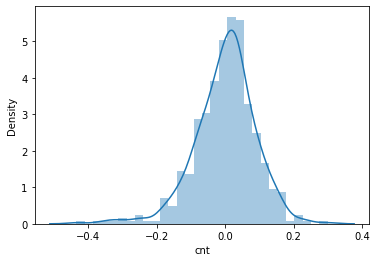

In [118]:
y_train_pred = regressor.predict(X_train_top13)
res = y_train - y_train_pred
sns.distplot(res)

## Prediction and Evaluation

In [119]:
numeric_var = ["temp", "atemp", "hum", "windspeed", "cnt"]
df_test[numeric_var] = scaler.transform(df_test[numeric_var])
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,July,June,Mar,May,Nov,Oct,Sept
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,...,0,0,0,1,0,0,0,0,0,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,1,...,0,0,0,0,1,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,0,0,0,0,0,0,0,0,1,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,0,1,...,0,0,0,0,1,0,0,0,0,0


In [120]:
y_test = df_test.pop('cnt')
X_test = df_test
X_test_sm = sm.add_constant(X_test)

In [121]:
X_test_sm = X_test_sm[top_13_cols]
y_test_pred = regressor.predict(X_test_sm)

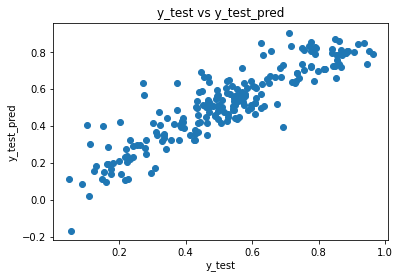

In [122]:
plt.scatter(y_test, y_test_pred)
plt.title('y_test vs y_test_pred')
plt.xlabel('y_test')
plt.ylabel('y_test_pred')      
plt.show()

### R2 Score

In [123]:
round(r2_score(y_true=y_test, y_pred=y_test_pred), 4)

0.8018